In [1]:
import openai
import pandas as pd
from sodapy import Socrata
# If downloading manually to ensure data isn't changing
#rat_df = pd.read_csv("Rat_Sightings_20240318.csv")

client = Socrata("data.cityofnewyork.us", None)
# this may take a minute
results = client.get("3q43-55fe", limit=2000)
# Convert to pandas DataFrame

rat_df = pd.DataFrame.from_records(results)
#rat_df = pd.json_normalize(results, "location")

print(rat_df.head)


<bound method NDFrame.head of         descriptor incident_zip x_coordinate_state_plane_  \
0     Rat Sighting        10021                    996796   
1     Rat Sighting        11374                   1024599   
2     Rat Sighting        10471                   1012894   
3     Rat Sighting        10460                   1016616   
4     Rat Sighting        11433                   1042611   
...            ...          ...                       ...   
1995  Rat Sighting        11201                    989518   
1996  Rat Sighting        10452                   1007550   
1997  Rat Sighting        10030                   1000823   
1998  Rat Sighting        10128                    998798   
1999  Rat Sighting        10028                    997076   

                 created_date  \
0     2024-03-23T01:07:26.000   
1     2024-03-22T23:08:31.000   
2     2024-03-22T23:05:00.000   
3     2024-03-22T22:35:17.000   
4     2024-03-22T22:05:54.000   
...                       ...   
1995  

In [2]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

location_flat = pd.DataFrame([flatten_json(x) for x in rat_df["location"]])
rat_df = pd.concat([rat_df.drop('location', axis=1), location_flat], axis=1)


So, I can't figure out why rat_df is not compatable with SmartDataFrame.  Rather than continue to use time on it, I'm just going to load it as the csv I downloaded

In [3]:

rat_df = pd.read_csv("Rat_Sightings_20240318.csv")


/var/folders/9k/2nrmc0kd5gqb3vj2r1r095p80000gn/T/ipykernel_47063/3141648726.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  rat_df = pd.read_csv("Rat_Sightings_20240318.csv")


In [4]:
from pandasai.llm import OpenAI
from pandasai import SmartDataframe
import folium
import os
plot_path = os.getcwd()
plot_path = plot_path + "/rat_plots"

openai_key = "YOURTOKENHERE"
oa_llm = OpenAI(api_token=openai_key)
smart_rat_df = SmartDataframe(rat_df, config={
    "llm": oa_llm,
    "save_charts": True,
    "save_charts_path": plot_path,
})
chat_details = []
#prompts = []
code_output_exe = [] # since they don't always have a value

Lets start simple and plot sightings vs time


/Users/rolandbennett/projects/Xarray/rat_plots/11ea25b8-a332-486f-b65c-1544b36309ac.png


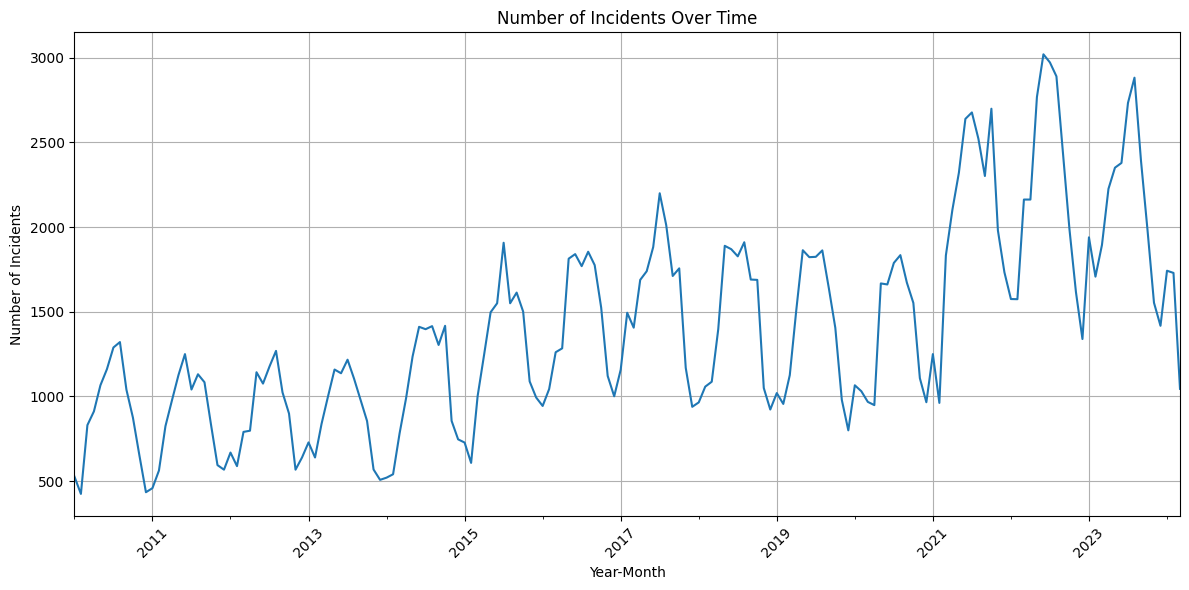

In [5]:
prompt = "Print plot number of incidents vs time"
response = smart_rat_df.chat(prompt)
print(response)
chat_details.append({
    "prompt" : prompt,
    "code_generated" : smart_rat_df.last_code_generated,
    "chat_response" :response
})
with open("chat_details.txt", "w") as file:
    content = "My prompt:\n" + prompt + "\n" + "code:\n" + smart_rat_df.last_code_generated + "\n" 
    if smart_rat_df.last_prompt is not None:
                   content += "LLM prompt:\n" + smart_rat_df.last_prompt + "\n" 
    if smart_rat_df.last_code_executed is not None:
        content += "code executed:\n" + smart_rat_df.last_code_executed + "\n"
    content += "\n"
    file.write(content)
    


Lets look at the code that Pandas AI generated.  The code in the cell directly below will print it and the cell two below will execute it.  The two manual additions are defining dfs and df and importing pyplot.  I am also changing the name of the plot that it saves to "manual_01" to avoid writing over the plot that was already made

In [6]:
print(chat_details)[prompt == "Print plot number of incidents vs time"]


[{'prompt': 'Print plot number of incidents vs time', 'code_generated': "dfs[0]['Created Date'] = pd.to_datetime(dfs[0]['Created Date'])\ndfs[0]['YearMonth'] = dfs[0]['Created Date'].dt.to_period('M')\nincident_count = dfs[0].groupby('YearMonth').size()\nplt.figure(figsize=(12, 6))\nincident_count.plot()\nplt.title('Number of Incidents Over Time')\nplt.xlabel('Year-Month')\nplt.ylabel('Number of Incidents')\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.savefig('/Users/rolandbennett/projects/Xarray/rat_plots/11ea25b8-a332-486f-b65c-1544b36309ac.png')\nresult = {'type': 'plot', 'value': '/Users/rolandbennett/projects/Xarray/rat_plots/11ea25b8-a332-486f-b65c-1544b36309ac.png'}", 'chat_response': '/Users/rolandbennett/projects/Xarray/rat_plots/11ea25b8-a332-486f-b65c-1544b36309ac.png'}]


TypeError: 'NoneType' object is not subscriptable

first we must manually define dfs. Also, I replaced dfs[0] with dfs


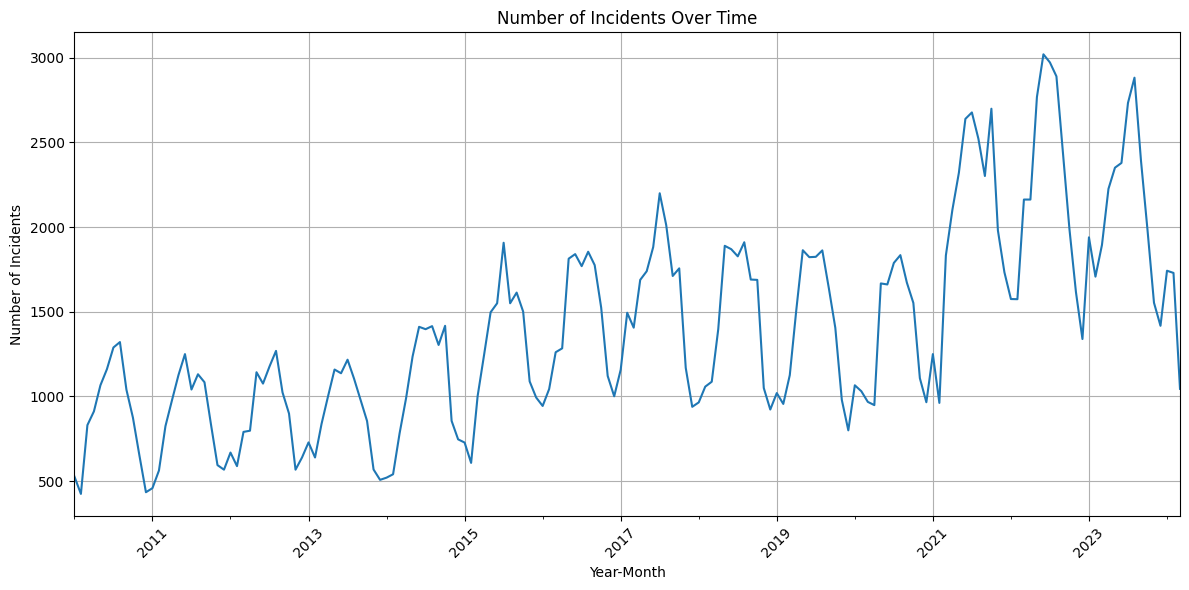

In [11]:

print("first we must manually define dfs. Also, I replaced dfs[0] with dfs")
dfs = smart_rat_df.dataframe.pandas_df
## also matplotlib.pyplot needs imported
import matplotlib.pyplot as plt

#dfs[0]['Created Date'] = pd.to_datetime(dfs[0]['Created Date'])
#dfs[0]['YearMonth'] = dfs[0]['Created Date'].dt.to_period('M')
dfs['Created Date'] = pd.to_datetime(dfs['Created Date'])
dfs['YearMonth'] = dfs['Created Date'].dt.to_period('M')
incident_count = dfs.groupby('YearMonth').size()
plt.figure(figsize=(12, 6))
incident_count.plot()
plt.title('Number of Incidents Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rat_plots/manual_plot_01.png')
result = {'type': 'plot', 'value': 'rat_plots/manual_plot_01.png'}

Lets trying doing this with openai, but not pandasai

In [12]:
from openai import OpenAI

client = OpenAI()

openai.api_key = openai_key
prompt =  smart_rat_df.last_prompt
print("Prompt Start: \n", prompt, "\n Prompt End: \n")
#prompt = "Print plot number of incidents vs time"
completion = openai.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt}
  ]
)

with open("openai_chat_details.txt", "a") as file:
    content = "LLM rompt:\n" + prompt + "\n" + "code:\n" 
    if completion.choices[0].message is not None:
                   content += "Message:\n" + completion.choices[0].message.content + "\n" 

    content += "\n"
    file.write(content)
    

print("\nMessage: ", completion.choices[0].message,  "\n")



Prompt Start: 
 dfs[0]:
  name: null
  description: null
  type: pd.DataFrame
  rows: 238558
  columns: 38
  schema:
    fields:
    - name: Unique Key
      type: int64
      samples:
      - 58597635
      - 50160771
      - 48597886
    - name: Created Date
      type: object
      samples:
      - 09/11/2020 02:52:53 PM
      - 01/07/2023 12:46:23 PM
      - 08/31/2023 05:05:37 AM
    - name: Closed Date
      type: object
      samples:
      - .nan
      - 04/13/2018 02:54:36 PM
      - 12/17/2015 10:00:55 AM
    - name: Agency
      type: object
      samples:
      - DOHMH
      - DOHMH
      - DOHMH
    - name: Agency Name
      type: object
      samples:
      - Department of Health and Mental Hygiene
      - Department of Health and Mental Hygiene
      - Department of Health and Mental Hygiene
    - name: Complaint Type
      type: object
      samples:
      - Rodent
      - Rodent
      - Rodent
    - name: Descriptor
      type: object
      samples:
      - Rat Sightin

Here I'll show you what I got 
dfs[0]:
  name: null
  description: null
  type: pd.DataFrame
  rows: 238558
  columns: 38
  schema:
    fields:
    - name: Unique Key
      type: int64
      samples:
      - 58597635
      - 50160771
      - 48597886
    - name: Created Date
      type: object
      samples:
      - 09/11/2020 02:52:53 PM
      - 01/07/2023 12:46:23 PM
      - 08/31/2023 05:05:37 AM
    - name: Closed Date
      type: object
      samples:
      - .nan
      - 04/13/2018 02:54:36 PM
      - 12/17/2015 10:00:55 AM
    - name: Agency
      type: object
      samples:
      - DOHMH
      - DOHMH
      - DOHMH
    - name: Agency Name
      type: object
      samples:
      - Department of Health and Mental Hygiene
      - Department of Health and Mental Hygiene
      - Department of Health and Mental Hygiene
    - name: Complaint Type
      type: object
      samples:
      - Rodent
      - Rodent
      - Rodent
    - name: Descriptor
      type: object
      samples:
      - Rat Sighting
      - Rat Sighting
      - Rat Sighting
    - name: Location Type
      type: object
      samples:
      - Hospital
      - .nan
      - Catch Basin/Sewer
    - name: Incident Zip
      type: float64
      samples:
      - 10013.0
      - .nan
      - 10455.0
    - name: Incident Address
      type: object
      samples:
      - 88 BAY    8 STREET
      - .nan
      - 200 WEST  136 STREET
    - name: Street Name
      type: object
      samples:
      - .nan
      - WILLIAMBRG ST EAST
      - HOWE STREET
    - name: Cross Street 1
      type: object
      samples:
      - GREENWOOD AVENUE PEDESTRIAN OVPS
      - .nan
      - FLOYD STREET
    - name: Cross Street 2
      type: object
      samples:
      - EAST  166 STREET
      - AUBREY AVENUE
      - .nan
    - name: Intersection Street 1
      type: object
      samples:
      - CAMBRIA STREET
      - ST NICOLAS AVE
      - .nan
    - name: Intersection Street 2
      type: object
      samples:
      - .nan
      - HOMECREST AVENUE
      - 144 PLACE
    - name: Address Type
      type: object
      samples:
      - .nan
      - LATLONG
      - BLOCKFACE
    - name: City
      type: object
      samples:
      - .nan
      - CENTRAL PARK
      - BROOKLYN
    - name: Landmark
      type: object
      samples:
      - 198 STREET
      - .nan
      - NORTHERN BOULEVARD
    - name: Facility Type
      type: float64
      samples:
      - .nan
      - .nan
      - .nan
    - name: Status
      type: object
      samples:
      - In Progress
      - Unspecified
      - Draft
    - name: Due Date
      type: object
      samples:
      - .nan
      - 07/31/2017 06:26:22 AM
      - 05/27/2010 02:25:53 PM
    - name: Resolution Action Updated Date
      type: object
      samples:
      - .nan
      - 08/10/2018 02:29:44 PM
      - 05/04/2022 09:31:34 PM
    - name: Community Board
      type: object
      samples:
      - 13 BROOKLYN
      - .nan
      - 08 MANHATTAN
    - name: Borough
      type: object
      samples:
      - .nan
      - QUEENS
      - BROOKLYN
    - name: X Coordinate (State Plane)
      type: float64
      samples:
      - .nan
      - 1018930.0
      - 1039674.0
    - name: Y Coordinate (State Plane)
      type: float64
      samples:
      - 192253.0
      - .nan
      - 187148.0
    - name: Park Facility Name
      type: object
      samples:
      - Unspecified
      - Unspecified
      - Unspecified
    - name: Park Borough
      type: object
      samples:
      - QUEENS
      - .nan
      - STATEN ISLAND
    - name: Vehicle Type
      type: float64
      samples:
      - .nan
      - .nan
      - .nan
    - name: Taxi Company Borough
      type: float64
      samples:
      - .nan
      - .nan
      - .nan
    - name: Taxi Pick Up Location
      type: float64
      samples:
      - .nan
      - .nan
      - .nan
    - name: Bridge Highway Name
      type: float64
      samples:
      - .nan
      - .nan
      - .nan
    - name: Bridge Highway Direction
      type: float64
      samples:
      - .nan
      - .nan
      - .nan
    - name: Road Ramp
      type: float64
      samples:
      - .nan
      - .nan
      - .nan
    - name: Bridge Highway Segment
      type: float64
      samples:
      - .nan
      - .nan
      - .nan
    - name: Latitude
      type: float64
      samples:
      - 40.88707032549229
      - 40.68008852991981
      - .nan
    - name: Longitude
      type: float64
      samples:
      - .nan
      - -73.96178338466348
      - -73.97188695698276
    - name: Location
      type: object
      samples:
      - (40.68663916109698, -73.95350411733371)
      - .nan
      - (40.75891422608703, -73.90799382164786)




Update this initial code:
```python
# TODO: import the required dependencies
import pandas as pd

# Write code here

# Declare result var: 
type (possible values "string", "number", "dataframe", "plot"). Examples: { "type": "string", "value": f"The highest salary is {highest_salary}." } or { "type": "number", "value": 125 } or { "type": "dataframe", "value": pd.DataFrame({...}) } or { "type": "plot", "value": "temp_chart.png" }

```



### QUERY
 Print plot number of incidents vs time

Variable `dfs: list[pd.DataFrame]` is already declared.

At the end, declare "result" variable as a dictionary of type and value.

If you are asked to plot a chart, use "matplotlib" for charts, save as png.


Generate python code and return full updated code:

I'm not seeing a plot, so lets inspect the code.  I am pasting this from my openai_chat_details file 

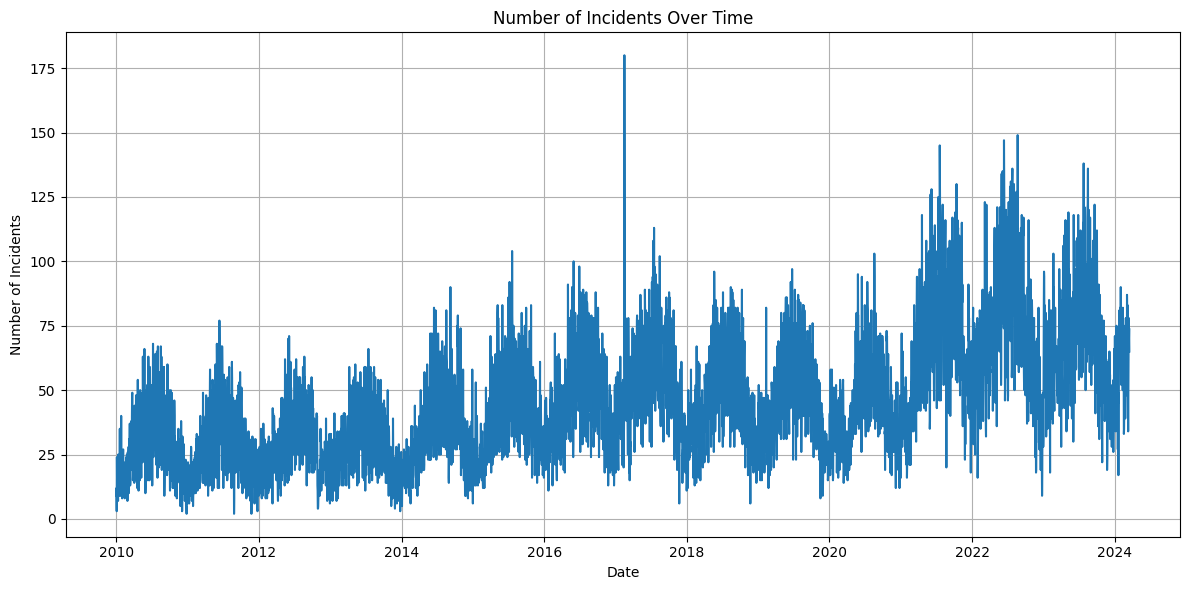

In [14]:

# Write code here
# manually define dfs
dfs = smart_rat_df.dataframe.pandas_df

# TODO: import the required dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Write code here
# Filter out rows with missing Created Date values
dfs = dfs[dfs['Created Date'].notnull()]

# Convert 'Created Date' to datetime format
dfs['Created Date'] = pd.to_datetime(dfs['Created Date'])

# Group by date and count the number of incidents
incidents_by_date = dfs.groupby(dfs['Created Date'].dt.date).size()

# Plot number of incidents vs time
plt.figure(figsize=(12, 6))
incidents_by_date.plot()
plt.title('Number of Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.tight_layout()

# Save the plot as png
plt.savefig('number_of_incidents_over_time.png')

# Declare result var
result = { "type": "plot", "value": "number_of_incidents_over_time.png" }

# Declare result var
result = { "type": "plot", "value": "incident_count_vs_time.png" }

Overall, very similar.  The call to the openAI model didn't create the plot. However, when I manually run the code that it produces, I do get a plot. There are some minor differences in the plots (such as color) but overall they present the same information.

Now lets try something more difficult- a heatmap

ERROR:pandasai.helpers.logger:Failed with error: Traceback (most recent call last):
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/chat/code_execution.py", line 64, in execute
    result = code_manager.execute_code(code_to_run, code_context)
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/helpers/code_manager.py", line 181, in execute_code
    code_to_run = self._clean_code(code, context)
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/helpers/code_manager.py", line 520, in _clean_code
    self._check_imports(node)
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/helpers/code_manager.py", line 611, in _check_imports
    raise BadImportError(library)
pandasai.exceptions.BadImportError: Generated code includes impo

<Figure size 1200x800 with 0 Axes>

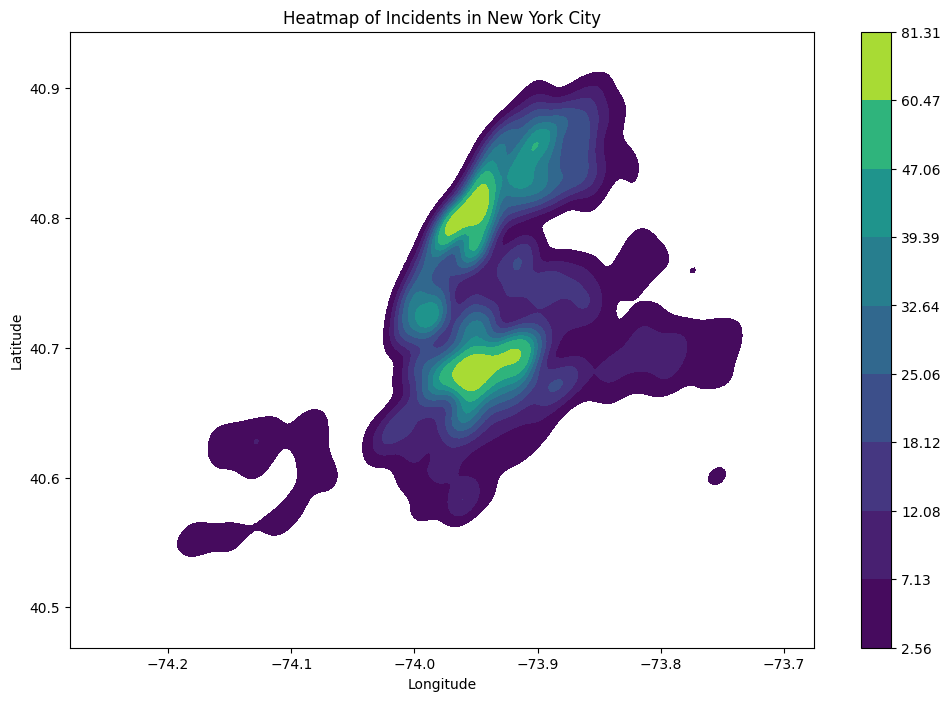

ERROR:pandasai.helpers.logger:Failed with error: Traceback (most recent call last):
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/chat/code_execution.py", line 64, in execute
    result = code_manager.execute_code(code_to_run, code_context)
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/helpers/code_manager.py", line 211, in execute_code
    raise NoResultFoundError("No result returned")
pandasai.exceptions.NoResultFoundError: No result returned

<string>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



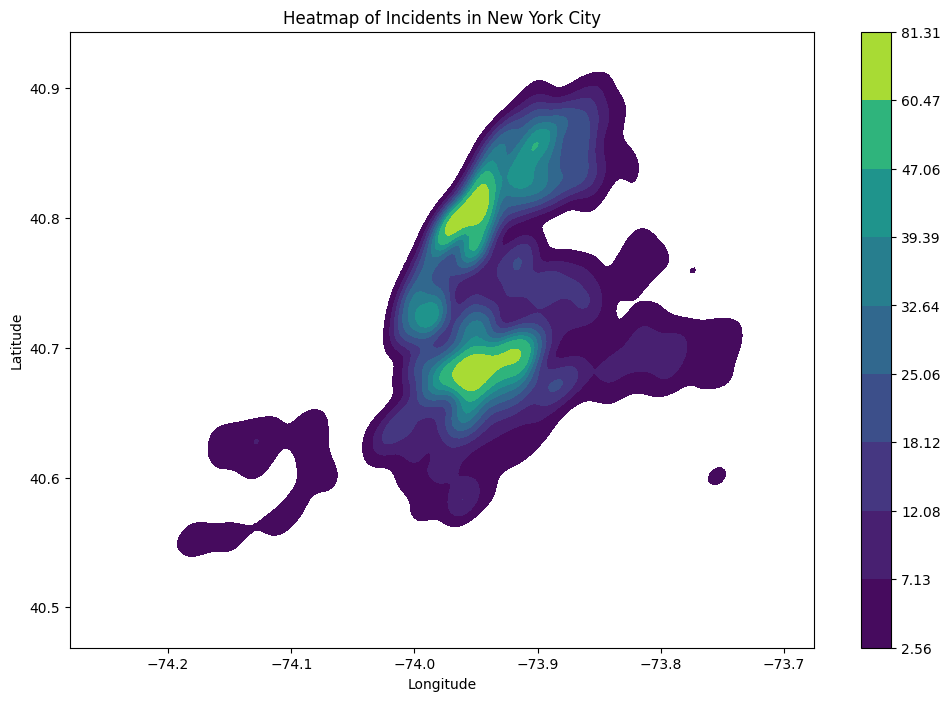

ERROR:pandasai.helpers.logger:Failed with error: Traceback (most recent call last):
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/chat/code_execution.py", line 64, in execute
    result = code_manager.execute_code(code_to_run, code_context)
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/helpers/code_manager.py", line 211, in execute_code
    raise NoResultFoundError("No result returned")
pandasai.exceptions.NoResultFoundError: No result returned

ERROR:pandasai.helpers.logger:Pipeline failed on step 5: No result returned
Traceback (most recent call last):
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 281, in run
    output = (self.code_generation_pipeline | self.code_execution_pipeline).run(
  File "/Users/rolandbennett/.pyenv

In [15]:
smart_rat_df = SmartDataframe(rat_df, config={
    "llm": oa_llm,
    "save_charts": True,
    "save_charts_path": plot_path,
})
prompt = "Plot a heatmap of incidents over a map of New York City"
response = smart_rat_df.chat(prompt)



Now, sometimes the above code throws an error and tells me that I need to import folium. Lets go ahead and reinitialize it with folium  

In [16]:
smart_rat_df = SmartDataframe(rat_df, config={
    "llm": oa_llm,
    "save_charts": True,
    "save_charts_path": plot_path,
    "custom_whitelisted_dependencies":["folium"],
})
prompt = "Plot a heatmap of incidents over a map of New York City"
response = smart_rat_df.chat(prompt)


ERROR:pandasai.helpers.logger:Pipeline failed on step 7: cannot identify image file 'nyc_heatmap.html'
Traceback (most recent call last):
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 281, in run
    output = (self.code_generation_pipeline | self.code_execution_pipeline).run(
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/chat/result_parsing.py", line 47, in execute
    result = parser.parse(result)
  File "/Users/rolandbennett/.pyenv/versions/

In [17]:
chat_details.append({
    "prompt" : prompt,
    "code_generated" : smart_rat_df.last_code_generated,
    "chat_response" :response
})

with open("chat_details.txt", "a") as file:
    content = "My prompt:\n" + prompt + "\n" + "code:\n" + smart_rat_df.last_code_generated + "\n" 
    if smart_rat_df.last_prompt is not None:
                   content += "LLM prompt:\n" + smart_rat_df.last_prompt + "\n" 
    if smart_rat_df.last_code_executed is not None:
        content += "code executed:\n" + smart_rat_df.last_code_executed + "\n"
    content += "\n"
    file.write(content)
    


I'm seeing an error 
PIL.UnidentifiedImageError: cannot identify image file 'nyc_heatmap.html'
that suggests that the module is making an html heatmap object (nice) and then trying to open it with the PIL function for opening images.  Silly. 
But lets now examine the code

In [18]:
print("first we must manually define dfs and df")
dfs = smart_rat_df.dataframe.pandas_df
df = dfs #[0][['Created Date']]
print("Also must manually import HeatMap function")
from folium.plugins import HeatMap

df = dfs[['Latitude', 'Longitude']].dropna()
nyc_map = folium.Map(location=[40.7128, -74.006], zoom_start=11)
HeatMap(data=df, radius=10).add_to(nyc_map)
nyc_map.save('nyc_heatmap.html')
result = {'type': 'plot', 'value': 'nyc_heatmap.html'}



first we must manually define dfs and df
Also must manually import HeatMap function


That error is telling us it can't open the .html object, but the code itself doesn't explicity do that. The pandasai chat function at some point calls
PIL.Image.open()
Which doesn't work because its trying to open an HTML object.  but this isn't reflected in the output of last_code_generated().  

Now we once again do this with openai directly

In [19]:
prompt =  smart_rat_df.last_prompt

print("Prompt Start: \n", prompt, "\n Prompt End: \n")
#prompt = "Print plot number of incidents vs time"
completion = openai.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt}
  ]
)

with open("openai_chat_details.txt", "a") as file:
    content = "LLM rompt:\n" + prompt + "\n" + "code:\n" 
    if completion.choices[0].message is not None:
                   content += "Message:\n" + completion.choices[0].message.content + "\n" 

    content += "\n"
    file.write(content)
    

print("\nMessage: ", completion.choices[0].message,  "\n")



Prompt Start: 
 None 
 Prompt End: 


BadRequestError: Error code: 400 - {'error': {'message': "Invalid value for 'content': expected a string, got null.", 'type': 'invalid_request_error', 'param': 'messages.[0].content', 'code': None}}

This is a problem.  Since the model is throwing an error at the end of its execution (not being able to open the html file), it appears that the last_prompt property doesn't get updated, and we don't have code to send to our openai model

For the final question, lets move away from visualization and do some analysis.  

In [20]:
smart_rat_df = SmartDataframe(rat_df, config={
    "llm": oa_llm,
    "save_charts": True,
    "save_charts_path": plot_path,
    "custom_whitelisted_dependencies":["folium"],
})
prompt = "Every day at 6 PM I walk from Washington Square Park to Chelsea Park.  I walk at 3 miles per hour. Please provide me a route that minimizes the number of rat sightings that occured on any day in the past within 10 minutes of the same time of time that I would walk by the location of the sighting on my evening walk. The route must be under 3 miles."
response = smart_rat_df.chat(prompt)


ERROR:pandasai.helpers.logger:Failed with error: Traceback (most recent call last):
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/pipelines/chat/code_execution.py", line 64, in execute
    result = code_manager.execute_code(code_to_run, code_context)
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/helpers/code_manager.py", line 181, in execute_code
    code_to_run = self._clean_code(code, context)
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/helpers/code_manager.py", line 520, in _clean_code
    self._check_imports(node)
  File "/Users/rolandbennett/.pyenv/versions/miniforge3-23.3.1-1/envs/Xarray/lib/python3.10/site-packages/pandasai/helpers/code_manager.py", line 611, in _check_imports
    raise BadImportError(library)
pandasai.exceptions.BadImportError: Generated code includes impo

In [21]:
chat_details.append({
    "prompt" : prompt,
    "code_generated" : smart_rat_df.last_code_generated,
    "chat_response" :response
})


with open("chat_details.txt", "a") as file:
    content = "My prompt:\n" + prompt + "\n" + "code:\n" + smart_rat_df.last_code_generated + "\n" 
    if smart_rat_df.last_prompt is not None:
                   content += "LLM prompt:\n" + smart_rat_df.last_prompt + "\n" 
    if smart_rat_df.last_code_executed is not None:
        content += "code executed:\n" + smart_rat_df.last_code_executed + "\n"
    content += "\n"
    file.write(content)
    



Alright, lets look at the code.  Note that this isn't always giving me the same result, so the code in your chat_details.txt file might not be the same


In [ ]:
rat_sightings = []
for df in dfs:
    rat_sightings.append(df[(df['Complaint Type'] == 'Rodent') & (df['Descriptor'] == 'Rat Sighting') & (df['Created Date'].dt.hour == 18) & (abs(df['Created Date'].dt.minute - 0) <= 10)])
possible_routes = ['Route A', 'Route B', 'Route C']


def calculate_total_distance(route):
    return 2.5


def is_within_route(latitude, longitude, route):
    return True


min_rat_sightings = float('inf')
optimal_route = None
for route in possible_routes:
    total_distance = calculate_total_distance(route)
    if total_distance <= 3:
        num_rat_sightings = 0
        for sighting in rat_sightings:
            for index, row in sighting.iterrows():
                if is_within_route(row['Latitude'], row['Longitude'], route):
                    num_rat_sightings += 1
        if num_rat_sightings < min_rat_sightings:
            min_rat_sightings = num_rat_sightings
            optimal_route = route
result = {'type': 'string', 'value': f'The optimal route with minimum rat sightings is {optimal_route}.'}





There are a few problems here.  First of all, it doesn't seem to know the streets of NYC.  It created routes A, B, and C as possible routes, but left them as these strings.  We would need to instruct it to use a package like OSMnx to build actual routes
Even if possible_routes did contain real routes, I wasn't asking it to compare different, predefined, routes to each other.  I'm asking to find the best route (minimum rat sightings) that is under 3 miles, which is a pretty complicated optimization problem when you have lots of different parallel streets. 

The calc_total_distance() function also will not work. It will simply return 2.5 every time.  This is pretty understandable, since the argument "route" that it takes isn't defined well. 
Also the is_within_route() function doesn't do anything at the moment.  I like the logic of using it, but currently it just returns True.  What it needs to do is determine if each rat sighting is along the route.  Since "walk by the location" is loosely defined.  Does this mean on the same segment of the street?

Ok when I reran this I got a totally different solution.  So I'll do some analysis for the new solution, which is below. Now we actually have function calculate_distance which calculates the distance.  The filter_rat_sightings function will filter all sightings that occured between 6:00 PM and 6:10 PM.  Alright, that's all sightings that occur within 10 minutes of my start time.  Not what we need, but it makes sense.  
The main function calculate_min_rat_route will calculate the distance each of the (filtered) sightings are from each park. Then it adds those two numbers and selects the rat sightings with the smallest combined distance.  Not what we want. 

In [23]:

def calculate_distance(lat1, lon1, lat2, lon2):
    lat1, lon1 = map(float, (lat1, lon1))
    lat2, lon2 = map(float, (lat2, lon2))
    return ((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2) ** 0.5


def filter_rat_sightings(df):
    rat_sightings = df[(df['Complaint Type'] == 'Rodent') & (df['Descriptor'] == 'Rat Sighting')]
    rat_sightings['Created Date'] = pd.to_datetime(rat_sightings['Created Date'])
    rat_sightings['Time'] = rat_sightings['Created Date'].dt.time
    rat_sightings_nearby = rat_sightings[(rat_sightings['Time'] >= pd.Timestamp('18:00:00').time()) & (rat_sightings['Time'] <= pd.Timestamp('18:10:00').time())]
    return rat_sightings_nearby


def calculate_min_rat_route(park1_lat, park1_lon, park2_lat, park2_lon, rat_sightings_df):
    min_distance = float('inf')
    min_route = None
    for df in rat_sightings_df:
        for index, row in df.iterrows():
            distance_park1 = calculate_distance(park1_lat, park1_lon, row['Latitude'], row['Longitude'])
            distance_park2 = calculate_distance(park2_lat, park2_lon, row['Latitude'], row['Longitude'])
            total_distance = distance_park1 + distance_park2
            if total_distance < min_distance and total_distance < 3:
                min_distance = total_distance
                min_route = row['Latitude'], row['Longitude']
    return min_route


filtered_rat_sightings = [filter_rat_sightings(df) for df in dfs]
washington_square_park = 40.730823, -73.997332
chelsea_park = 40.7465, -74.001374
min_route = calculate_min_rat_route(washington_square_park[0], washington_square_park[1], chelsea_park[0], chelsea_park[1], filtered_rat_sightings)
result = {'type': 'string', 'value': f'The route with minimum rat sightings is at coordinates: {min_route}'}


TypeError: string indices must be integers

In [24]:
prompt =  smart_rat_df.last_prompt

print("Prompt Start: \n", prompt, "\n Prompt End: \n")
#prompt = "Print plot number of incidents vs time"
completion = openai.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt}
  ]
)

with open("openai_chat_details.txt", "a") as file:
    content = "LLM rompt:\n" + prompt + "\n" + "code:\n" 
    if completion.choices[0].message is not None:
                   content += "Message:\n" + completion.choices[0].message.content + "\n" 

    content += "\n"
    file.write(content)
    

print("\nMessage: ", completion.choices[0].message,  "\n")

Prompt Start: 
 dfs[0]:
  name: null
  description: null
  type: pd.DataFrame
  rows: 238558
  columns: 39
  schema:
    fields:
    - name: Unique Key
      type: int64
      samples:
      - 26582547
      - 58225567
      - 39377985
    - name: Created Date
      type: datetime64[ns]
      samples:
      - !!python/object/apply:pandas._libs.tslibs.timestamps._unpickle_timestamp
        - 1566744071000000000
        - null
        - null
        - 10
      - !!python/object/apply:pandas._libs.tslibs.timestamps._unpickle_timestamp
        - 1598208935000000000
        - null
        - null
        - 10
      - !!python/object/apply:pandas._libs.tslibs.timestamps._unpickle_timestamp
        - 1705299881000000000
        - null
        - null
        - 10
    - name: Closed Date
      type: object
      samples:
      - 01/25/2024 10:36:11 PM
      - 03/24/2021 09:55:21 AM
      - .nan
    - name: Agency
      type: object
      samples:
      - DOHMH
      - DOHMH
      - DOHMH
    - n

Lets inspect the code that openai creates

In [25]:
# TODO: import the required dependencies
import pandas as pd

# Calculate distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    lat_lon_1 = (lat1, lon1)
    lat_lon_2 = (lat2, lon2)
    return geopy.distance.distance(lat_lon_1, lat_lon_2).miles

# Filter rat sightings within 10 minutes of 6 PM
def filter_rat_sightings(df):
    rat_sightings = df[(df['Complaint Type'] == 'Rodent') & (df['Descriptor'] == 'Rat Sighting')]
    rat_sightings['Created Date'] = pd.to_datetime(rat_sightings['Created Date'])
    rat_sightings['Time'] = rat_sightings['Created Date'].dt.time
    rat_sightings_nearby = rat_sightings[(rat_sightings['Time'] >= pd.Timestamp('18:00:00').time()) & 
                                         (rat_sightings['Time'] <= pd.Timestamp('18:10:00').time())]
    return rat_sightings_nearby

# Calculate the route with minimum rat sightings
def calculate_min_rat_route(park1_lat, park1_lon, park2_lat, park2_lon, rat_sightings_df):
    min_distance = float('inf')
    min_route = None
    for df in rat_sightings_df:
        for index, row in df.iterrows():
            distance_park1 = calculate_distance(park1_lat, park1_lon, row['Latitude'], row['Longitude'])
            distance_park2 = calculate_distance(park2_lat, park2_lon, row['Latitude'], row['Longitude'])
            total_distance = distance_park1 + distance_park2
            if total_distance < min_distance and total_distance < 3:
                min_distance = total_distance
                min_route = (row['Latitude'], row['Longitude'])
    return min_route

# Filter rat sightings within 10 minutes of 6 PM
filtered_rat_sightings = [filter_rat_sightings(df) for df in dfs]

# Washington Square Park coordinates
washington_square_park = (40.730823, -73.997332)

# Chelsea Park coordinates
chelsea_park = (40.746500, -74.001374)

# Calculate the route with minimum rat sightings
min_route = calculate_min_rat_route(washington_square_park[0], washington_square_park[1], chelsea_park[0], chelsea_park[1], filtered_rat_sightings)

result = {"type": "string", "value": f"The route with minimum rat sightings is at coordinates: {min_route}"}


TypeError: string indices must be integers

This is pretty similar to what pandasai did (the second time).  It suffers the same primary errors- it is just seeing which rat sighting that occured between 6:00 and 6:10 PM was closest to the two parks.  
Going deep into how I would solve this problem would take quite some time.  I don't really want to take the time to do that right now, but you could grill me on it in the interview if you'd like